In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import ADASYN
import os
import spacy
from collections import Counter
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [3]:
# Membaca dataset dengan pengecekan encoding
df = pd.read_csv('data/origin-data/google-play-rev-gen-2.csv', encoding='utf-8')

# Memeriksa beberapa baris pertama
df.head(10)

,id,title,avatar,rating,snippet,likes,date,iso_date,response
0,e5384431-56f9-43fa-a32a-53296afc7f66,Seraphim,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,"While I've reviewed this before, I decided to ...",88,"October 09, 2024",2024-10-09T00:08:20Z,NaN
1,6a73081f-3490-47ba-89fa-83744cb20940,TWOSTORE !,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,Very fun but I wish there was more fighting in...,35,"October 12, 2024",2024-10-12T06:39:01Z,NaN
2,3a3d4c90-0b6e-45dc-b1e6-014659055bbf,A G,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,"Fun game, I enjoy the story. There is tons to ...",11,"October 30, 2024",2024-10-30T18:01:37Z,NaN
3,99015538-1d26-4bd9-a02f-37bc2a361d1a,Astra,https://play-lh.googleusercontent.com/a-/ALV-U...,5.0,This game is phenomenal. The art style and sce...,77,"October 18, 2024",2024-10-18T19:11:12Z,NaN
4,541b3b4d-97f6-42e0-9c68-059a63e1e67f,Angela Williams,https://play-lh.googleusercontent.com/a-/ALV-U...,2.0,"I love this game. However, it is incredibly la...",14,"October 14, 2024",2024-10-14T03:04:43Z,NaN
5,ad484b6a-1b9c-42ab-9cee-9df6e28f12d4,Valerie,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,I used to be obsessed with this game but I hav...,99,"October 13, 2024",2024-10-13T14:02:08Z,NaN
6,fb25cdf6-40d8-44e8-b1b9-d439ebd88565,Daniel “Chotara” Ricciardi,https://play-lh.googleusercontent.com/a-/ALV-U...,5.0,Highly recommend. I have been playing the game...,65,"October 18, 2024",2024-10-18T15:20:11Z,NaN
7,36e821d3-9441-4eaa-94a7-9c7b9b7463b5,Amy,https://play-lh.googleusercontent.com/a-/ALV-U...,4.0,Hello! I absolutely love this game! It has inc...,29,"October 29, 2024",2024-10-29T00:27:08Z,NaN
8,4b1e6dcb-d251-450e-9be6-358b4bb8e9d6,Feitan Desy,https://play-lh.googleusercontent.com/a-/ALV-U...,4.0,I've been playing this game since January 16th...,64,"October 08, 2024",2024-10-08T23:13:09Z,NaN
9,27525772-1c0a-40e4-8321-4c5f0a0f7c64,Olivia Staringer,https://play-lh.googleusercontent.com/a-/ALV-U...,1.0,"Uninteresting characters, uninteresting dialog...",14,"November 11, 2024",2024-11-11T22:58:07Z,NaN


In [4]:
df = df.drop(columns=['id', 'title', 'avatar', 'date', 'iso_date', 'response'])

In [5]:
# Define the function to classify ratings
def classify_rating(rating):
    if rating in [3, 4, 5]:
        return 'positive'
    elif rating in [1, 2]:
        return 'negative'
    return 'unknown'

# Apply the classification function to create the 'rating_label' column
df['rating_label'] = df['rating'].apply(classify_rating)

# Pisahkan data ke dalam kelas positive dan negative
positive_data = df[df['rating_label'] == 'positive']
negative_data = df[df['rating_label'] == 'negative']

In [6]:
def clean_text(text):
    # Menghapus URL
    text = re.sub(r'http\S+', '', text)
    # Menghapus emoji
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Menghapus karakter non-alfabet
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    # Menghapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan pembersihan teks pada kolom review
df['cleaned_snippet'] = df['snippet'].apply(clean_text)

# Hapus kolom 'snippet' setelah pembersihan
df.drop(columns=['snippet'], inplace=True)


In [7]:
# Preprocess function using spaCy (lemmatization and stop word removal)
def preprocess_with_spacy(text):
    doc = nlp(str(text))
    cleaned_text = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(cleaned_text)

# Preprocess the 'cleaned_snippet' column
df['cleaned_snippet'] = df['cleaned_snippet'].apply(preprocess_with_spacy)

# Split the data into features (X) and target (y)
X = df['cleaned_snippet']  # Cleaned text
y = df['rating_label']  # Sentiment label

# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
# from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Apply ADASYN to generate synthetic data for the minority class (negative reviews)
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X_train_vec, y_train)

# Convert resampled data back to text using inverse_transform
resampled_reviews = vectorizer.inverse_transform(X_resampled)
resampled_reviews_cleaned = [' '.join(review) for review in resampled_reviews]

# Apply spaCy preprocessing to the synthetic data
resampled_reviews_final = [preprocess_with_spacy(review) for review in resampled_reviews_cleaned]

# Create DataFrame for the resampled data
df_resampled = pd.DataFrame({
    'cleaned_snippet': resampled_reviews_final,
    'rating_label': y_resampled
})

# Merge the original training data with the synthetic data
df_train_balanced = pd.concat([df[['cleaned_snippet', 'rating_label']], df_resampled], ignore_index=True)

# Display the new distribution of labels in the balanced training data
print("\nJumlah data setelah ADASYN augmentasi:")
print(df_train_balanced['rating_label'].value_counts())

# Save the balanced dataset to a new CSV file
output_directory = 'data/new-changedData'
os.makedirs(output_directory, exist_ok=True)
balanced_output_file_path = os.path.join(output_directory, 'balanced-google-play-rev-gen-2.csv')
df_train_balanced.to_csv(balanced_output_file_path, index=False)
print(f"Balanced dataset saved to: {balanced_output_file_path}")


Jumlah data setelah ADASYN augmentasi:
rating_label
positive    279
negative    163
Name: count, dtype: int64
Balanced dataset saved to: data/new-changedData/balanced-google-play-rev-gen-2.csv


In [8]:
df.head()

,rating,likes,rating_label,cleaned_snippet
0,3.0,88,positive,ve review decide edit response current opinion...
1,3.0,35,positive,fun wish fighting quest bunch talk run come qu...
2,3.0,11,positive,fun game enjoy story ton ton content clear bor...
3,5.0,77,positive,game phenomenal art style scenery stunning yes...
4,2.0,14,negative,love game incredibly laggy point unplayable gr...


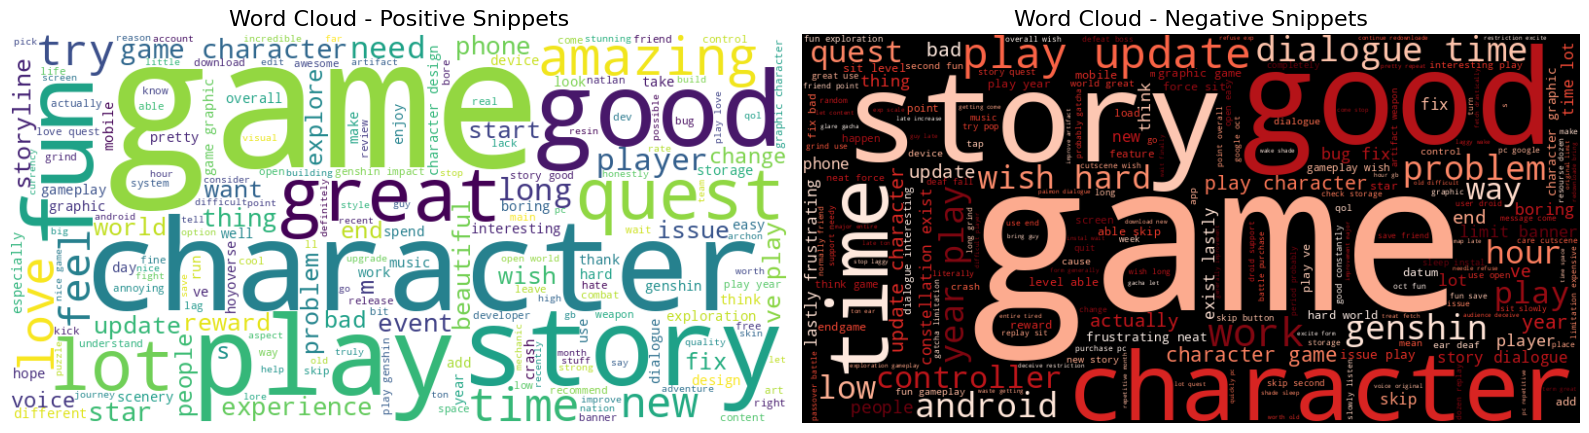

In [9]:
# Load the dataset
df = pd.read_csv('data/new-changedData/balanced-google-play-rev-gen-2.csv', encoding='utf-8')

# Filter positive and negative snippets
positive_snippets = df[df['rating_label'] == 'positive']['cleaned_snippet']
negative_snippets = df[df['rating_label'] == 'negative']['cleaned_snippet']

# Combine all positive and negative snippets into single strings
positive_text = " ".join(positive_snippets.dropna())
negative_text = " ".join(negative_snippets.dropna())

# Generate word clouds for positive and negative snippets
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Create a subplot for word clouds
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[0].set_title('Word Cloud - Positive Snippets', fontsize=16)
ax[0].axis('off')

ax[1].imshow(wordcloud_negative, interpolation='bilinear')
ax[1].set_title('Word Cloud - Negative Snippets', fontsize=16)
ax[1].axis('off')

plt.tight_layout()
plt.show()


In [10]:
# Load the cleaned data
df = pd.read_csv('data/new-changedData/balanced-google-play-rev-gen-2.csv', encoding='utf-8')

# Add review length as a feature
df['review_length'] = df['cleaned_snippet'].apply(len)

# Add sentiment polarity score as a feature
df['sentiment_score'] = df['cleaned_snippet'].apply(lambda x: TextBlob(x).sentiment.polarity)

# TF-IDF vectorization with refined settings
tfidf = TfidfVectorizer(max_features=5000, max_df=0.5, min_df=0.01, stop_words='english')
X_tfidf = tfidf.fit_transform(df['cleaned_snippet']).toarray()

# Combine TF-IDF features with additional features
tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out())

# Scale the additional features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['review_length', 'sentiment_score']])
scaled_features_df = pd.DataFrame(scaled_features, columns=['review_length', 'sentiment_score'])

# Combine scaled additional features with TF-IDF features
X = pd.concat([tfidf_df, scaled_features_df], axis=1)

y = df['rating_label']

# Save the new DataFrame with TF-IDF and additional features
df_tfidf = pd.concat([df[['rating_label']], X], axis=1)
df_tfidf.to_csv('data/new-changedData/google-play-rev-gen-2-TF_IDF-enhanced.csv', index=False)

# Print results
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print("\nFirst 10 rows of the new data with enhanced features:")
print(df_tfidf.head(10))

Feature matrix shape: (442, 589)
Target variable shape: (442,)

First 10 rows of the new data with enhanced features:
  rating_label      able  absolutely  absurd  abyss  account  achievement  \
0     positive  0.000000     0.00000     0.0    0.0      0.0          0.0   
1     positive  0.000000     0.00000     0.0    0.0      0.0          0.0   
2     positive  0.193242     0.00000     0.0    0.0      0.0          0.0   
3     positive  0.000000     0.00000     0.0    0.0      0.0          0.0   
4     negative  0.000000     0.00000     0.0    0.0      0.0          0.0   
5     positive  0.000000     0.00000     0.0    0.0      0.0          0.0   
6     positive  0.000000     0.24099     0.0    0.0      0.0          0.0   
7     positive  0.000000     0.22343     0.0    0.0      0.0          0.0   
8     positive  0.000000     0.00000     0.0    0.0      0.0          0.0   
9     negative  0.000000     0.00000     0.0    0.0      0.0          0.0   

   act  action  actual  ...  wise 

In [11]:
# Load the dataset with TF-IDF features
df_tfidf = pd.read_csv('data/new-changedData/google-play-rev-gen-2-TF_IDF-enhanced.csv', encoding='utf-8')

# Extract the feature matrix (X) and target variable (y)
X = df_tfidf.drop(columns=['rating_label'])  # Drop the 'rating_label' column to get the features
y = df_tfidf['rating_label']  # Target variable is the 'rating_label'

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution before ADASYN
print("Class distribution before ADASYN:", Counter(y_train))

# Initialize ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=5)  # `n_neighbors` can be adjusted based on your dataset

# Apply ADASYN to the training data
try:
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
except ValueError as e:
    print(f"Error during ADASYN resampling: {e}")
    exit()

# Check class distribution after ADASYN
print("Class distribution after ADASYN:", Counter(y_train_adasyn))

# Display the shape of the new oversampled training set
print(f"Shape of X_train_adasyn: {X_train_adasyn.shape}")
print(f"Shape of y_train_adasyn: {y_train_adasyn.shape}")

Class distribution before ADASYN: Counter({'positive': 223, 'negative': 130})
Class distribution after ADASYN: Counter({'negative': 230, 'positive': 223})
Shape of X_train_adasyn: (453, 589)
Shape of y_train_adasyn: (453,)


In [12]:
# Train an SVM model
svm_model = SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced', random_state=42)
svm_model.fit(X_train_adasyn, y_train_adasyn)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Evaluation Metrics:
Accuracy: 0.8989
F1-Score (Weighted): 0.9005

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      1.00      0.88        33
    positive       1.00      0.84      0.91        56

    accuracy                           0.90        89
   macro avg       0.89      0.92      0.90        89
weighted avg       0.92      0.90      0.90        89


Confusion Matrix:
[[33  0]
 [ 9 47]]
